In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import pandas as pd
import math
from matplotlib.patches import Polygon
from google.colab import drive





In [ ]:
# Input

NPE=4                                      # Node per element
df=2                                       # Degree of freedom per element


zeta, eta = sym.symbols('zeta eta ')       # Symolic variables

#Elastic constant
e=200*10**9
nu=0.3

#Traction                                  # Boundary condition
Tx=7*10**9    #N/m

In [ ]:
#Plane stress
E=(e/(1-nu**2))*sym.Matrix([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])


In [ ]:
# Weights and Integration points
# Using 2 point integration method

weight=np.matrix([1,1])
integrating_points=np.matrix([[np.sqrt(1/3),-np.sqrt(1/3)],[np.sqrt(1/3),-np.sqrt(1/3)]])

In [ ]:
# Quadratic nodal element
# Shape Funcrion
N1 =1/4*(zeta-1)*(eta-1)
N2 =-1/4*(zeta+1)*(eta-1)
N3 =1/4*(zeta+1)*(eta+1)
N4 =-1/4*(zeta-1)*(eta+1)

N=sym.Matrix([N1,N2,N3,N4])

In [ ]:
#Derivative of shape Function

# w.r.t. zeta
dzetaN=N.diff(zeta)

# w.r.t. eta
detaN=N.diff(eta)

In [ ]:

# Function for generating uniform mesh

def uniform_mesh(NOE_x,NOE_y,q):

    # NOE_x,NOE_y,q are input variables to function
    # NOE_x = Number of nodes in x direction
    # NOE_y = Number of nodes in y direction
    # q = Coordinates points of domain



    df=2                                               # DOF per node
    NON=(NOE_x+1)*(NOE_y+1)                            # Number of node in domian

    NOE=NOE_x*NOE_y                                    # Number of element in domain
    NPE=4
    NL=np.zeros((NON,df))

    mesh_size_x=(q[1,0]-q[0,0])/NOE_x

    mesh_size_y=(q[2,1]-q[0,1])/NOE_y

    mesh_size=np.array([mesh_size_x,mesh_size_y])

    NL_uni=np.zeros((NON,df))

    for i in range(0,NOE_y+1):
      for j in range(0,NOE_x+1):
        NL_uni[i*NOE_x+i+j,0]=q[0,0]+j*mesh_size_x
        NL_uni[i*NOE_x+i+j,1]=q[0,1]+i*mesh_size_y



    return NL_uni,NON,NOE,mesh_size

In [ ]:

def void_mesh(a,b,NOE_x,NOE_y,r):
  q=np.array([[0,0],[a,0],[0,b],[a,b]])
  df=2
  NON=(NOE_x+1)*(NOE_y+1)+(NOE_x)*(NOE_y+1)
  NOE=2*NOE_x*NOE_y
  NPE=4
  NL=np.zeros((NON,df))

  dx=(q[1,0]-q[0,0])/NOE_x

  dy=(q[2,1]-q[0,1])/NOE_x

  coord_1=np.zeros(((NOE_x+1)*(NOE_y+1),df))
  for i in range(1,NOE_x+2):
    coord_1[i-1,0]=q[2,0]+(i-1)*dx
    coord_1[i-1,1]=q[2,1]



  for i in range(1,NOE_x+2):
    coord_1[NOE_y*(NOE_x+1)+i-1,0]=r*np.cos(math.pi/2-(i-1)*(math.pi/(4*NOE_x)))
    coord_1[NOE_y*(NOE_x+1)+i-1,1]=r*np.sin(math.pi/2-(i-1)*(math.pi/(4*NOE_x)))

  for i in range(1,NOE_y):
    for j in range(1,NOE_x+2):
      dx1=(-coord_1[j-1,0]+coord_1[NOE_y*(NOE_x+1)+j-1,0])/NOE_y
      dy1=(-coord_1[j-1,1]+coord_1[NOE_y*(NOE_x+1)+j-1,1])/NOE_y

      coord_1[(i)*(NOE_x+1)+j-1,0]=coord_1[(i-1)*(NOE_x+1)+j-1,0]+dx1
      coord_1[(i)*(NOE_x+1)+j-1,1]=coord_1[(i-1)*(NOE_x+1)+j-1,1]+dy1


  coord_2=np.zeros(((NOE_x)*(NOE_y+1),df))
  for i in range(1,NOE_x+1):
    coord_2[i-1,0]=q[3,0]
    coord_2[i-1,1]=q[2,1]-i*dy



  for i in range(1,NOE_x+1):
    coord_2[NOE_y*(NOE_x)+i-1,0]=r*np.cos(math.pi/4-(i)*(math.pi/(4*NOE_x)))
    coord_2[NOE_y*(NOE_x)+i-1,1]=r*np.sin(math.pi/4-(i)*(math.pi/(4*NOE_x)))

  for i in range(1,NOE_y):
    for j in range(1,NOE_x+1):
      dx1=(-coord_2[j-1,0]+coord_2[NOE_y*(NOE_x)+j-1,0])/NOE_y
      dy1=(-coord_2[j-1,1]+coord_2[NOE_y*(NOE_x)+j-1,1])/NOE_y

      coord_2[(i)*(NOE_x)+j-1,0]=coord_2[(i-1)*(NOE_x)+j-1,0]+dx1
      coord_2[(i)*(NOE_x)+j-1,1]=coord_2[(i-1)*(NOE_x)+j-1,1]+dy1

  # Reordering nodes


  p=1
  q=0
  for i in range(1, NOE_y + 2):
      NL[(i - 1)*2*NOE_x+q:i*2*NOE_x+p, :] = np.vstack([coord_1[(i - 1)*(NOE_x+1 ):i*(NOE_x+1 ), :],
                                                           coord_2[(i - 1)*NOE_x:i * NOE_x, :]])
      p=p+1
      q=q+1


  return NL ,NON,NOE



In [ ]:

# Assembly
def patch_area(NL_in1,NL_in2,NL_in3,NL_in4,NOE_in_x1,NOE_in_y1,
               NOE_in_x2,NOE_in_y2,NOE_in_x3,NOE_in_y3,NOE_in_x4,NOE_in_y4):



    index= len(NL_in1)+len(NL_in2)+len(NL_in3)+len(NL_in4)-2*(NOE_in_x1+1)-(NOE_in_y2+1)-(NOE_in_x3)


    NL_global=np.zeros((index,df))



    common_node_a3  = np.arange(0, len(NL_in3), NOE_in_x3+1)


    mask_a3 = np.ones(len(NL_in3), dtype=bool)
    mask_a3[common_node_a3] = False


    common_node_a4  = np.arange(0, len(NL_in4), NOE_in_x4+1)


    mask_a4 = np.ones(len(NL_in4), dtype=bool)
    mask_a4[common_node_a4] = False

    NL_a5=NL_in4[mask_a4]


    NL_global[:,:] =np.vstack([NL_in1[: , :],NL_in2[(NOE_in_x1+1):, :],NL_in3[ mask_a3],NL_a5[(NOE_in_x3):,:]])

    return NL_global




In [ ]:


def element_coord(NOE_in1,NOE_in2,NOE_in3,NOE_in4,NOE_in_x1,NOE_in_y1,NOE_in_x2,NOE_in_y2,NOE_in_x3,
                  NOE_in_y3,NOE_in_x4,NOE_in_y4,NON_in1,NON_in2,NON_in3,NON_in4,NPE):
    EL=np.zeros((NOE_in1+NOE_in2+NOE_in3+NOE_in4,NPE))
    p=0


    # For area 1
    for i in range(0,NOE_in_y1):
        for j in range(0,2*NOE_in_x1):


           EL[(i)*2*NOE_in_x1+j,3]=(i)*2*NOE_in_x1+j+p
           EL[(i)*2*NOE_in_x1+j,2]=EL[(i)*2*NOE_in_x1+j,3]+1
           EL[(i)*2*NOE_in_x1+j,0]=EL[(i)*2*NOE_in_x1+j,3]+(2*NOE_in_x1+1)
           EL[(i)*2*NOE_in_x1+j,1]=EL[(i)*2*NOE_in_x1+j,0]+1
        p=p+1


    # For area 2
    p=NOE_a1


    for i in range(0,NOE_in_y2):
        for j in range(0,NOE_in_x2):
           if i ==0:
              EL[p,0]= i*(NOE_in_x2+1)+j
              EL[p,1]=EL[p,0]+1
              EL[p,3]=NON_in1+i*(NOE_in_x2+1)+j
              EL[p,2]=EL[p,3]+1
              p=p+1

           else:
              EL[p,0]= (i-1)*(NOE_in_x2+1)+j+NON_in1
              EL[p,1]=EL[p,0]+1
              EL[p,3]=NON_in1+i*(NOE_in_x2+1)+j
              EL[p,2]=EL[p,3]+1
              p=p+1



    # For area 3
    p=NOE_a1+NOE_a2


    for i in range(0,NOE_in_y3):
        for j in range(0,NOE_in_x3):
           if j ==0:
              EL[p,0]= 2*(NOE_in_x1)+j-i
              EL[p,1]=NON_in1+NON_in2-(NOE_in_x1+1)+j+i*NOE_in_x3
              EL[p,3]= EL[p,0]-1
              EL[p,2]=EL[p,1]+NOE_in_x3


           else:

              EL[p,0]= NON_in1+NON_in2-(NOE_in_x1+1)+i*(NOE_in_x3)+(j-1)
              EL[p,1]=EL[p,0]+1
              EL[p,3]=NON_in1+NON_in2-(NOE_in_x1+1)+(i+1)*NOE_in_x3+(j-1)
              EL[p,2]=EL[p,3]+1

           p=p+1



    # For area 4
    p=NOE_in1+NOE_in2+NOE_in3


    for i in range(0,NOE_in_y4):
        for j in range(0,NOE_in_x4):
          if i==0:
               if j ==0:
                  EL[p,0]= NOE_in_x1
                  EL[p,1]=NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)-(i+1)*NOE_in_x4
                  EL[p,3]= NON_in1+NOE_in_x1
                  EL[p,2]=NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)-i*NOE_in_x4

               else:

                  EL[p,0]= NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)-(i+1)*NOE_in_x4+(j-1)
                  EL[p,1]=EL[p,0]+1
                  EL[p,3]=NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)-(i)*NOE_in_x4+(j-1)
                  EL[p,2]=EL[p,3]+1

          elif j==0:

                EL[p,0]= NON_in1+i*(NOE_in_x1)+(i-1)
                EL[p,1]= NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)+(i-1)*NOE_in_x4
                EL[p,3]= NON_in1+(i+1)*NOE_in_x1+i
                EL[p,2]= NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)+i*NOE_in_x4

          else:

                EL[p,0]= NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)+(i-1)*NOE_in_x4+(j-1)
                EL[p,1]=EL[p,0]+1
                EL[p,3]=NON_in1+NON_in2+NON_in3-2*(NOE_in_x1+1)+(i)*NOE_in_x4+(j-1)
                EL[p,2]=EL[p,3]+1


          p=p+1

    EL1=EL.astype(int)
    return EL1



In [ ]:

def draw_line1(NL_in,EL_in ):
    for i in range(0,len(EL_in)):

            point1=NL_in[EL_in[i,0]]
            point2=NL_in[EL_in[i,1]]
            point3=NL_in[EL_in[i,2]]
            point4=NL_in[EL_in[i,3]]


            x_values1 = [point1[0], point2[0]]
            y_values1 = [point1[1], point2[1]]

            x_values2 = [point3[0], point4[0]]
            y_values2 = [point3[1], point4[1]]


            x_values3 = [point1[0], point4[0]]
            y_values3 = [point1[1], point4[1]]

            x_values4 = [point3[0], point2[0]]
            y_values4 = [point3[1], point2[1]]

            plt.plot(x_values1, y_values1, marker='o')  # 'o' represents points at the end of the line
            plt.plot(x_values2, y_values2, marker='o')  # 'o' represents points at the end of the line

            plt.plot(x_values3, y_values3, marker='o')  # 'o' represents points at the end of the line
            plt.plot(x_values4, y_values4, marker='o')  # 'o' represents points at the end of the line


    plt.xlabel('X (in meter)')
    plt.ylabel('Y (in meter)')
    plt.title('Displacement Field')
    plt.grid(True)
    plt.show()


In [ ]:

#  Aproximating x and y
def x_mat(i,EL_in,NL_in):
    x_array= np.matrix([NL_in[EL_in[i,0],0],NL_in[EL_in[i,1],0],NL_in[EL_in[i,2],0],NL_in[EL_in[i,3],0]])
    return x_array
def y_mat(i,EL_in,NL_in):
    y_array= np.matrix([NL_in[EL_in[i,0],1],NL_in[EL_in[i,1],1],NL_in[EL_in[i,2],1],NL_in[EL_in[i,3],1]])
    return y_array

In [ ]:

def approx_x(i,EL_in,NL_in):
    X=np.dot(np.transpose(N),np.transpose(x_mat(i,EL_in,NL_in)))
    return X

def approx_y(i,EL_in,NL_in):
    Y=np.dot(np.transpose(N),np.transpose(y_mat(i,EL_in,NL_in)))
    return Y

In [ ]:

def derivative_x(i,EL_in,NL_in):

     dxdzeta=np.dot(np.transpose(dzetaN),np.transpose(x_mat(i,EL_in,NL_in)))
     dxdeta=np.dot(np.transpose(detaN),np.transpose(x_mat(i,EL_in,NL_in)))
     return dxdzeta,dxdeta


def derivative_y(i,EL_in,NL_in):
     dydzeta=np.dot(np.transpose(dzetaN),np.transpose(y_mat(i,EL_in,NL_in)))
     dydeta=np.dot(np.transpose(detaN),np.transpose(y_mat(i,EL_in,NL_in)))
     return dydzeta,dydeta

In [ ]:
# Jacobian
def jacob(i,EL_in,NL_in):
    uzeta,ueta=derivative_x(i,EL_in,NL_in)
    vzeta,veta=derivative_y(i,EL_in,NL_in)
    J1=np.array([[uzeta,vzeta],[ueta,veta]])
    J2=np.reshape(J1,(2,2))
    J=sym.Matrix(J2)
    determinant = J.det()
    inverse=J.inv()
    return J,determinant,inverse


In [ ]:

def B_local(i,EL_in,NL_in):
    _,determinant,inv_J = jacob(i,EL_in,NL_in)


    B=sym.zeros(3,8)
    p=0
    q=1
    for k in range(0,4):


        dndx=(inv_J[0,0]*dzetaN[k,0]+inv_J[0,1]*detaN[k,0])
        dndy=(inv_J[1,0]*dzetaN[k,0]+inv_J[1,1]*detaN[k,0])


        B[0, p]=dndx
        B[1, q]=dndy
        B[2, p]=dndy
        B[2, q]=dndx
        p=p+2
        q=q+2

    return B,determinant

In [ ]:
# For elemental Stiffness Matrix
def elemental_stiffness(i,EL_in,NL_in):
  B,determinant=B_local(i,EL_in,NL_in)
  K_temp=B.transpose()*E*B*determinant
  K_elemental=np.zeros((8,8))
  for p in range(0,2):
    for q in range(0,2):

       value={zeta:integrating_points[p,q],eta:integrating_points[q,p]}
       K_elemental=K_temp.subs(value)+K_elemental

  return K_elemental

In [ ]:

def K_global(i,EL_in,NL_in):
      K_elemental=elemental_stiffness(i,EL_in,NL_in)
      index=EL_in[i,:]
      K_g=np.zeros((df*len(NL_in),df*len(NL_in)))
      t=0
      for p in range(0,4):
          r=0
          s=1
          ii=t

          for q in range(0,4):
              K_g[index[p]*df,index[q]*df]=K_elemental[t,r]
              K_g[index[p]*df,index[q]*df+1]=K_elemental[t,s]

              t=t+1
              K_g[index[p]*df+1,index[q]*df]=K_elemental[t,r]
              K_g[index[p]*df+1,index[q]*df+1]=K_elemental[t,s]

              r=r+2
              s=s+2
              t=ii
          t=t+2
      return K_g

In [ ]:
# Boundary condition
def boundary_element(NOE_in1,NOE_in2,NOE_in3,NOE_in4,NOE_in_x1,NOE_in_y1,NOE_in_x2,NOE_in_y2,NOE_in_x3,
                  NOE_in_y3,NOE_in_x4,NOE_in_y4):
    left_list=[]

    bottom_list=[]


    right_list=[]

    # Area 1

    for i in range(0,NOE_in_y1):

        index_l=i*2*NOE_in_x1
        index_b=(i+1)*2*NOE_in_x1-1


        left_list.append(index_l)
        bottom_list.append(index_b)


    # Area 2
    for i in range(0,NOE_in_y2):
        index_l=NOE_a1+NOE_in_x2*i
        left_list.append(index_l)


    # Area 3
    for i in range(0,NOE_in_x3):
        index_b=NOE_in1+NOE_in2+i
        bottom_list.append(index_b)

    for i in range(0,NOE_in_y3):
        index_r=NOE_in1+NOE_in2+NOE_in_x3*(i+1)-1
        right_list.append(index_r)


    # Area 4
    for i in range(0,NOE_in_y4):
        index_r=NOE_in1+NOE_in2+NOE_in3+NOE_in_x4*(i+1)-1
        right_list.append(index_r)


    left_boundary=np.array(left_list)
    right_boundary=np.array(right_list)
    bottom_boundary=np.array((bottom_list),dtype=int)

    return left_boundary,bottom_boundary,right_boundary






In [ ]:

def boundary_nodes(left_boundary_in,bottom_boundary_in,right_boundary_in,EL_in):
    left_list=[]
    right_list=[]
    bottom_list=[]

    # Left Nodes
    for i in range(0,len(left_boundary_in)):

        index_l=EL_in[left_boundary_in[i],0]
        left_list.append(index_l)

    index_l=EL_in[left_boundary_in[i],3]
    left_list.append(index_l)


     # bottom Nodes
    for i in range(0,len(bottom_boundary_in)):
         if i==0:
            index_b=EL_in[bottom_boundary_in[i],2]
            bottom_list.append(index_b)

            index_b=EL_in[bottom_boundary_in[i],1]
            bottom_list.append(index_b)
         else:

            index_b=EL_in[bottom_boundary_in[i],1]
            bottom_list.append(index_b)

    # right Nodes
    for i in range(0,len(right_boundary_in)):
         if i==0:
            index_r=EL_in[right_boundary_in[i],1]
            right_list.append(index_r)

            index_r=EL_in[right_boundary_in[i],2]
            right_list.append(index_r)
         else:

            index_r=EL_in[right_boundary_in[i],2]
            right_list.append(index_r)



    left_nodes=np.array(left_list)
    right_nodes=np.array(right_list)
    bottom_nodes=np.array(bottom_list)


    index_1=left_nodes*2
    index_increament=np.ones((len(bottom_nodes)),dtype=int)
    index_2=bottom_nodes*2+index_increament

    new_index=np.zeros((len(left_nodes)+len(bottom_nodes)))

    new_index1=np.concatenate((index_1,index_2))
    sorted_index=sorted(new_index1)
    new_index=np.array(sorted_index)
    return left_nodes,bottom_nodes,right_nodes,new_index




In [ ]:

def boundary_force(Tx,EL_in,NL_in,right_nodes_in,right_boundary_in):

    force=np.zeros((len(NL_in)*2,1))

    for jj in range(0,len(right_boundary_in)):
        f_temp=np.zeros((len(NL_in)*2,1))
        J,_,_ = jacob(right_boundary_in[jj],EL_in,NL_in)
        multi_factor=sym.sqrt(J[1,0]**2+J[1,1]**2)
        f_temp[2*right_nodes_in[jj]]=Tx* multi_factor
        f_temp[2*right_nodes_in[jj+1]]=Tx* multi_factor
        force += f_temp
    return force


In [ ]:

def reduce_matrix(K_in,force_vector_in,new_index_in):

   # Left boundary condition



   K_r=np.delete(K_in,new_index_in,axis=0)
   K_n=np.delete(K_r,new_index_in,axis=1)
   force=np.delete(force_vector_in,new_index_in,axis=0)



   return K_n,force







In [ ]:

def add_row(displacement_in,new_index_in):
    # Adding Left nodes
   row_index=np.zeros((len(new_index_in)),dtype=int)
   boudary_node=np.array(0)
   for i in range(0,len(new_index_in)):
       row_index[i]=new_index_in[i]-i

   displacement=np.insert(displacement_in,row_index,boudary_node,axis=0)


   return  displacement,row_index





In [ ]:

# Mesh convergence analysis


# Inputs
l1=0.6                     # lenght in x direction
h1=0.6                     # Lenght in y direction
r1=l1/6                    # Radius of hole


# For Area 1 ( left bottom)
a1=0.5*l1                 # Length of Sqaure/2
b1=0.5*h1


NOE_x1_a=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15],dtype=int)                 # Number of elements in area 1
NOE_y1_a=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15],dtype=int)

#NOE_x1_a=np.array([3],dtype=int)                 # Number of elements in area 1
#NOE_y1_a=np.array([3],dtype=int)

# Area 2                (Left top)

a2=a1
b2=(h1-b1)


NOE_x2_a=NOE_x1_a                # Number of elements in area 2
NOE_y2_a=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15],dtype=int)
#NOE_y2_a=np.array([3],dtype=int)
q2=np.array([[0,b1],[a2,b1],[0,h1],[a2,h1]])

# Area 3            (Right bottom)

a3=(l1-a1)
b3=b1


NOE_x3_a=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15],dtype=int)            # Number of elements in area 3
#NOE_x3_a=np.array([3],dtype=int)
NOE_y3_a=NOE_x1_a

q3=np.array([[a1,0],[l1,0],[a1,b1],[l1,b1]])

#Area 4

a4=a3
b4=b2

NOE_x4_a=NOE_x3_a                # Number of elements in area 4
NOE_y4_a=NOE_y2_a

q4=np.array([[a1,b1],[l1,b1],[a1,h1],[l1,h1]])

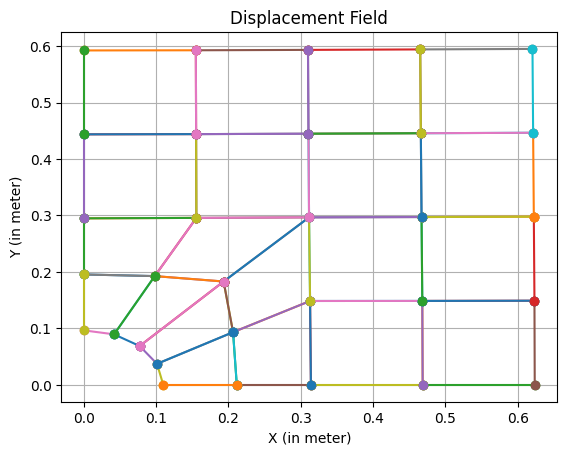

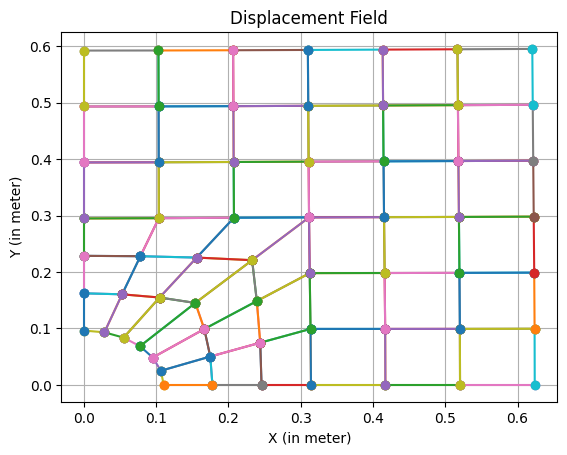

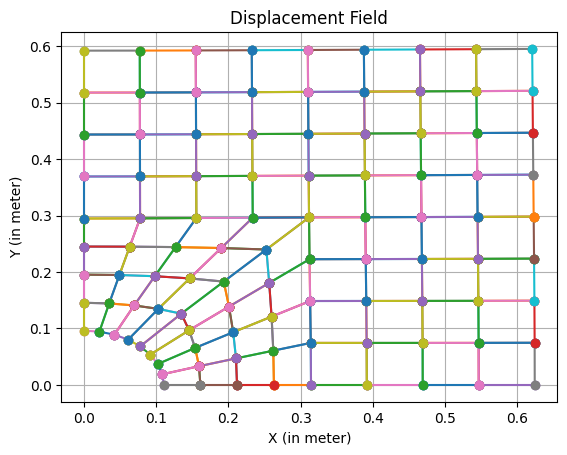

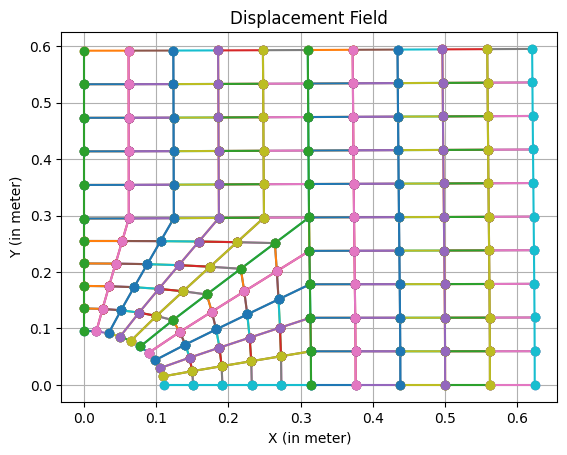

In [ ]:
total_node_list=[]
displacement_list=[]

epsilon=0.01
for i in range(0,len(NOE_x1_a)):




    NL_a2,NON_a2,NOE_a2,mesh_size_a2=uniform_mesh(NOE_x2_a[i],NOE_y2_a[i],q2)
    NL_a3,NON_a3,NOE_a3,mesh_size_a3=uniform_mesh(NOE_x3_a[i],NOE_y3_a[i],q3)
    NL_a4,NON_a4,NOE_a4,mesh_size_a4=uniform_mesh(NOE_x4_a[i],NOE_y4_a[i],q4)

    NL_a1,NON_a1,NOE_a1=void_mesh(a1,b1,NOE_x1_a[i],NOE_y1_a[i],r1)

    NL_global_a=patch_area(NL_a1,NL_a2,NL_a3,NL_a4,NOE_x1_a[i],NOE_y1_a[i],NOE_x2_a[i],
                           NOE_y2_a[i],NOE_x3_a[i],NOE_y3_a[i],NOE_x4_a[i],NOE_y4_a[i])

    EL_a=element_coord(NOE_a1,NOE_a2,NOE_a3,NOE_a4,NOE_x1_a[i],NOE_y1_a[i],NOE_x2_a[i],
                       NOE_y2_a[i],NOE_x3_a[i],NOE_y3_a[i],NOE_x4_a[i],NOE_y4_a[i],NON_a1,NON_a2,NON_a3,NON_a4,NPE)


    K_a=np.zeros((df*len(NL_global_a),df*len(NL_global_a)))

    for j in range(0,len(EL_a)):

         K_a=K_a+K_global(j,EL_a,NL_global_a)



    left_boundary_a,bottom_boundary_a,right_boundary_a=boundary_element(NOE_a1,NOE_a2,NOE_a3,NOE_a4,NOE_x1_a[i],
                                                              NOE_y1_a[i],NOE_x2_a[i],NOE_y2_a[i],NOE_x3_a[i],
                                                             NOE_y3_a[i],NOE_x4_a[i],NOE_y4_a[i])



    left_nodes,bottom_nodes,right_nodes,new_index_a=boundary_nodes(left_boundary_a,bottom_boundary_a,right_boundary_a,EL_a)


    force_vector_a=boundary_force(Tx,EL_a,NL_global_a,right_nodes,right_boundary_a)



    reduced_K_a,reduced_force_a=reduce_matrix(K_a,force_vector_a,new_index_a)


    displacement_a = np.linalg.solve(reduced_K_a, reduced_force_a)


    full_displacement_a,row_index=add_row(displacement_a,new_index_a)


    reshaped_displacement_a = full_displacement_a.reshape(-1, 2)




    NL_global_new_a=NL_global_a+reshaped_displacement_a

    #draw_line1(NL_global_a,EL_a )

    draw_line1(NL_global_new_a,EL_a )



    total_node_list.append(len(EL_a))

    displacement_list.append(full_displacement_a[2*right_nodes[-1]])

    #displacement_list.append(np.linalg.norm(full_displacement_a))

    y_value=np.array(displacement_list)


    if i>0 and abs(y_value[i]-y_value[i-1])*100/y_value[i-1]<epsilon:                    # stopping criteria difference L2 norm  between
                                                                        # previous iterarion and current < tolerance


       dispacement_vector=full_displacement_a
       NL_final=NL_global_new_a
       EL_final= EL_a

       NOE_x1_F=NOE_x1_a[i]
       NOE_y1_F=NOE_y1_a[i]

       NOE_x2_F=NOE_x2_a[i]
       NOE_y2_F=NOE_y2_a[i]

       NOE_x3_F=NOE_x3_a[i]
       NOE_y3_F= NOE_y3_a[i]


       NOE_x4_F=NOE_x4_a[i]
       NOE_y4_F=NOE_y4_a[i]




       break

print('Iteration :',i+1)





In [ ]:
print(displacement_list)
print(y_value)

In [ ]:


# Plot of Total number of elements and displacement of a node
x_data=np.array(total_node_list)
y_data=np.array(displacement_list)
plt.plot(x_data,y_data, marker='o')

plt.xlabel('Number of Elements')
plt.ylabel('Displacement of point A')
plt.title('Mesh Convergence Analysis')
plt.grid(True)
plt.show()


In [ ]:

# Strain Field

def strain(displacement_in,EL_in,NL_in):

    stain_list=[]
    for i in range(0,len(EL_in)):

        u_temp=sym.Matrix([displacement_in[2*EL_in[i,0]],displacement_in[2*EL_in[i,0]+1],
                     displacement_in[2*EL_in[i,1]],displacement_in[2*EL_in[i,1]+1],
                     displacement_in[2*EL_in[i,2]],displacement_in[2*EL_in[i,2]+1],
                     displacement_in[2*EL_in[i,3]],displacement_in[2*EL_in[i,3]]+1])

        B,_=B_local(i,EL_in,NL_in)



        strain_temp=B*u_temp
        local_strain=np.zeros((3,1))


        value={zeta:0,eta:0}
        local_strain=strain_temp.subs(value)

        stain_list.append(local_strain)

    strain_field=np.array(stain_list,dtype=float)

    return strain_field
strain_field=strain(dispacement_vector,EL_final,NL_final)

In [ ]:
#print(strain_field)
strain_field.dtype

In [ ]:

def stress(stain_in,E_in):

    stress_list=[]
    for i in range(0,len(stain_in)):
        stress_temp=np.dot(E_in,stain_in[i])

        stress_list.append(stress_temp)

    stress_local=np.array(stress_list,dtype=float)

    return stress_local

stress_local=stress(strain_field,E)

In [ ]:
print(stress_local[44])

In [ ]:

def coord(EL_in,NL_in):

    coord_list=[]
    for i in range(0, len(EL_in)):
        x_data=x_mat(i,EL_in,NL_in)
        y_data=y_mat(i,EL_in,NL_in)

        coordinate = np.array([[x_data[0,0], y_data[0,0]], [x_data[0,1], y_data[0,1]], [x_data[0,2],y_data[0,2]], [x_data[0,3], y_data[0,3]]])

        coord_list.append(coordinate)


    coordinate_list=np.array(coord_list)

    return coordinate_list

coordinate_list=coord(EL_final,NL_final)







In [ ]:

def plot_stress(stress_in,coordinate_in):

    for i in range(0,3):

        stress=stress_in[:,i,:]

        min_stress = np.min(stress)
        max_stress = np.max(stress)

        plt.figure(figsize=(8, 6))

        # Plot each element with stress as a colormap
        for el, s in zip(coordinate_list, stress):
            polygon = Polygon(el, closed=True, edgecolor='black',
                      facecolor=plt.cm.viridis(s / max(stress)), alpha=0.7)
            plt.gca().add_patch(polygon)

        # Add colorbar
        plt.axis('equal')
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_stress, vmax=max_stress))
        sm.set_array([])
        plt.colorbar(sm, label='Stress')

        stress_components = {0: 'sigma_xx', 1: 'sigma_yy', 2: 'sigma_xy'}
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Stress Field -{stress_components[i]} ')
        plt.grid(False)
        plt.show()




In [ ]:


def plot_strain(strain_in,coordinate_in):

    for i in range(0,3):

        strain=strain_in[:,i,:]

        min_strain = np.min(strain)
        max_strain = np.max(strain)

        plt.figure(figsize=(8, 6))

        # Plot each element with stress as a colormap
        for el, s in zip(coordinate_list, strain):
            polygon = Polygon(el, closed=True, edgecolor='black',
                      facecolor=plt.cm.viridis(s / max(strain)), alpha=0.7)
            plt.gca().add_patch(polygon)

        # Add colorbar
        plt.axis('equal')
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_strain, vmax=max_strain))
        sm.set_array([])
        plt.colorbar(sm, label='strain')

        strain_components = {0: 'epsilon_xx', 1: 'epsilon_yy', 2: 'gamma_xy'}
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Strain Field -{strain_components[i]} ')
        plt.grid(False)
        plt.show()

In [ ]:

def strain_energy(strain_in,stress_in):

    strain_energy_list=[]
    for i in range(0,len(strain_in)):
        stress = np.array([[stress_in[i,0,0], stress_in[i,2,0]],
                   [stress_in[i,2,0], stress_in[i,1,0]]])                #  stress tensor
        strain = np.array([[strain_in[i,0,0], strain_in[i,2,0]],
                   [strain_in[i,2,0],strain_in[i,1,0]]])                 #  strain tensor

    # strain energy density
    strain_energy_density = 0.5 * np.tensordot(stress, strain)

    strain_energy_list.append(strain_energy_density)


    # Total Strain Energy
    total_strain_energy = np.sum(strain_energy_density)


    return total_strain_energy




In [ ]:

TSE=strain_energy(strain_field,stress_local)
print(TSE)

In [ ]:
# keeping a/r  = constat
# For converged mesh



# Input
l2=np.linspace(0.6,6.6,5)                    # lenght in x direction
h2=l2                     # Lenght in y direction
r2=l2/6


# For Area 1 ( left bottom)
a1=0.5*l2                 # Length of Sqaure/2
b1=0.5*h2




# Area 2                (Left top)
a2=a1
b2=(h2-b1)


#q2=np.array([[0,b1],[a2,b1],[0,h2],[a2,h2]])

# Area 3            (Right bottom)
a3=(l2-a1)
b3=b1

#q3=np.array([[a1,0],[l2,0],[a1,b1],[l2,b1]])

# Area 4             (Right top)
a4=a3
b4=b2

#q4=np.array([[a1,b1],[l2,b1],[a1,h2],[l2,h2]])


In [ ]:

for i in range(0,len(l2)):
    q2=np.array([[0,b1[i]],[a2[i],b1[i]],[0,h2[i]],[a2[i],h2[i]]])

    q3=np.array([[a1[i],0],[l2[i],0],[a1[i],b1[i]],[l2[i],b1[i]]])

    q4=np.array([[a1[i],b1[i]],[l2[i],b1[i]],[a1[i],h2[i]],[l2[i],h2[i]]])





    NL_a2,NON_a2,NOE_a2,mesh_size_a2=uniform_mesh(NOE_x2_F,NOE_y2_F,q2)
    NL_a3,NON_a3,NOE_a3,mesh_size_a3=uniform_mesh(NOE_x3_F,NOE_y3_F,q3)
    NL_a4,NON_a4,NOE_a4,mesh_size_a4=uniform_mesh(NOE_x4_F,NOE_y4_F,q4)

    NL_a1,NON_a1,NOE_a1=void_mesh(a1[i],b1[i],NOE_x1_F,NOE_y1_F,r2[i])

    NL_global_a=patch_area(NL_a1,NL_a2,NL_a3,NL_a4,NOE_x1_F,NOE_y1_F,NOE_x2_F,
                           NOE_y2_F,NOE_x3_F,NOE_y3_F,NOE_x4_F,NOE_y4_F)

    EL_a=element_coord(NOE_a1,NOE_a2,NOE_a3,NOE_a4,NOE_x1_F,NOE_y1_F,NOE_x2_F,
                       NOE_y2_F,NOE_x3_F,NOE_y3_F,NOE_x4_F,NOE_y4_F,NON_a1,NON_a2,NON_a3,NON_a4,NPE)


    K_a=np.zeros((df*len(NL_global_a),df*len(NL_global_a)))

    for j in range(0,len(EL_a)):

         K_a=K_a+K_global(j,EL_a,NL_global_a)


    left_boundary_a,bottom_boundary_a,right_boundary_a=boundary_element(NOE_a1,NOE_a2,NOE_a3,NOE_a4,NOE_x1_F,
                                                              NOE_y1_F,NOE_x2_F,NOE_y2_F,NOE_x3_F,
                                                             NOE_y3_F,NOE_x4_F,NOE_y4_F)



    left_nodes,bottom_nodes,right_nodes,new_index_a=boundary_nodes(left_boundary_a,bottom_boundary_a,right_boundary_a,EL_a)


    force_vector_a=boundary_force(Tx,EL_a,NL_global_a,right_nodes,right_boundary_a)


    reduced_K_a,reduced_force_a=reduce_matrix(K_a,force_vector_a,new_index_a)


    displacement_a = np.linalg.solve(reduced_K_a, reduced_force_a)


    full_displacement_a,row_index=add_row(displacement_a,new_index_a)


    reshaped_displacement_a = full_displacement_a.reshape(-1, 2)




    NL_global_new_a=NL_global_a+reshaped_displacement_a

    #draw_line1(NL_global_a,EL_a )

    draw_line1(NL_global_new_a,EL_a )

    strain_field=strain(full_displacement_a,EL_a,NL_global_a)


    stress_local=stress(strain_field,E)

    coordinate_list=coord(EL_final,NL_global_a)

    plot_stress(stress_local,coordinate_list)

    plot_strain( strain_field,coordinate_list)

